File loaded successfully! First few rows:
      timestamp                   datetime can_id           payload  \
0  1.536574e+09 2018-09-10 10:06:04.242068    1C8  83FF0000FFFE3BFF   
1  1.536574e+09 2018-09-10 10:06:04.242212    1E9  0000000E00010000   
2  1.536574e+09 2018-09-10 10:06:04.242485    232  0000000000000000   
3  1.536574e+09 2018-09-10 10:06:04.242641    348        000000001B   
4  1.536574e+09 2018-09-10 10:06:04.242807    34A        000000001B   

   payload_length  
0              16  
1              16  
2              16  
3              10  
4              10  
Computed statistics successfully!

Descriptive Statistics:

BASIC Statistics:
total_messages: 2690069
unique_can_ids: 85
data_duration_seconds: 1382.225713968277
messages_per_second: 1946.1864822909372

CAN_ID Statistics:
most_frequent_can_id: 1E5
messages_most_frequent: 138277
least_frequent_can_id: 120
messages_least_frequent: 276

TEMPORAL Statistics:
mean_interval: 0.0005138255664794634
median_interval: 

<Figure size 1200x800 with 0 Axes>

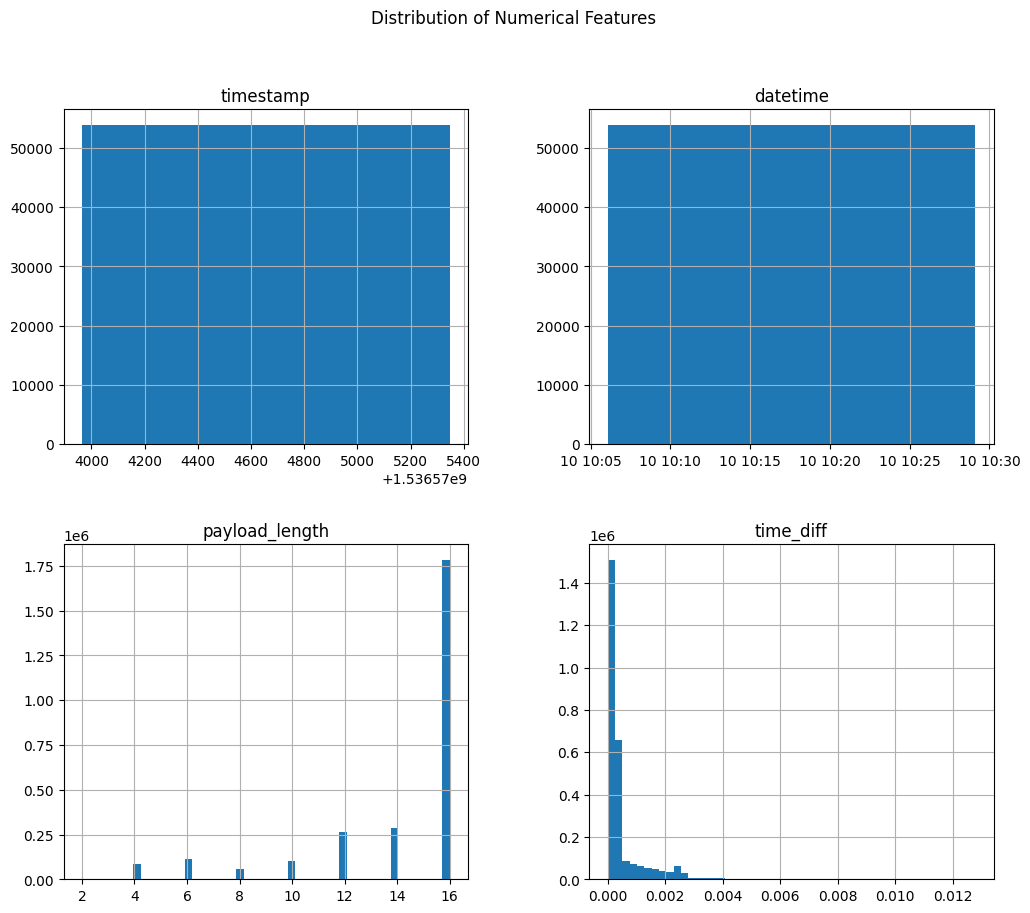

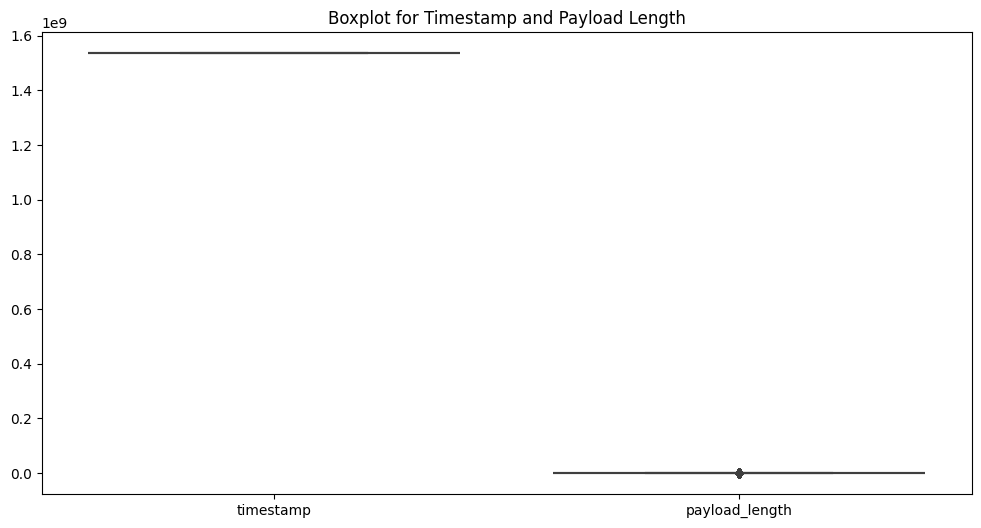

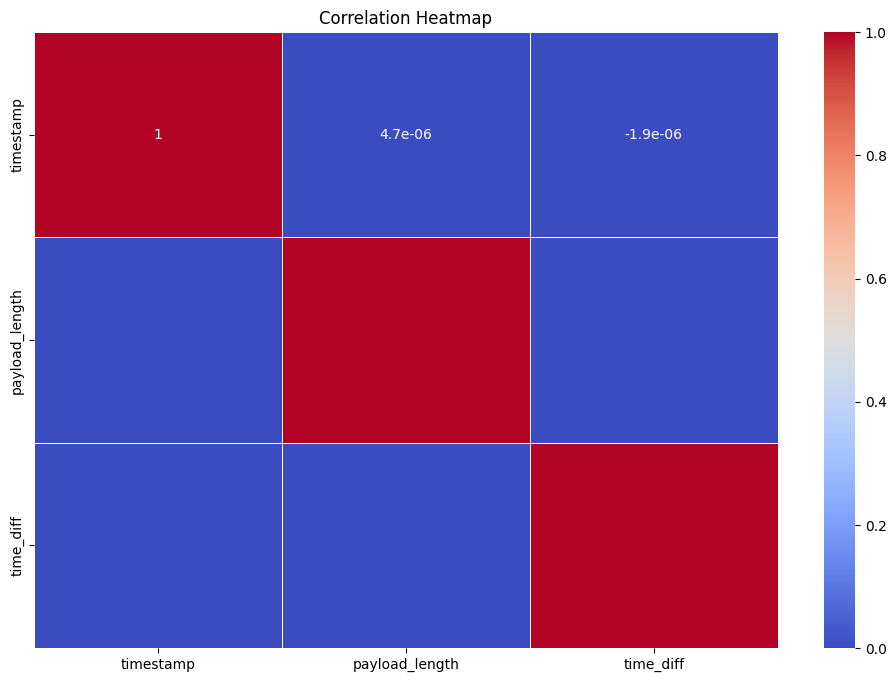

/usr/local/lib64/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


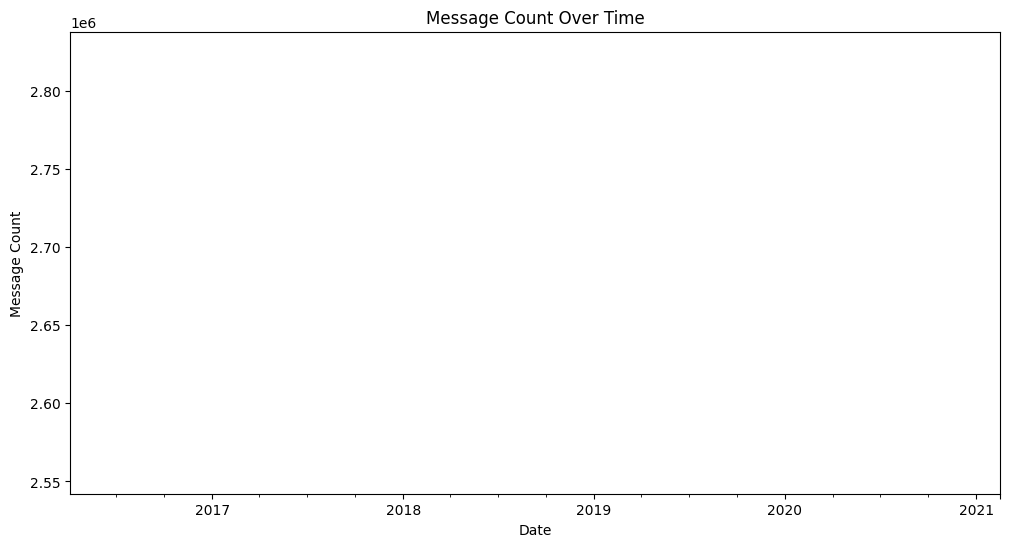

Missing Data:
 timestamp         0
datetime          0
can_id            0
payload           0
payload_length    0
time_diff         1
dtype: int64


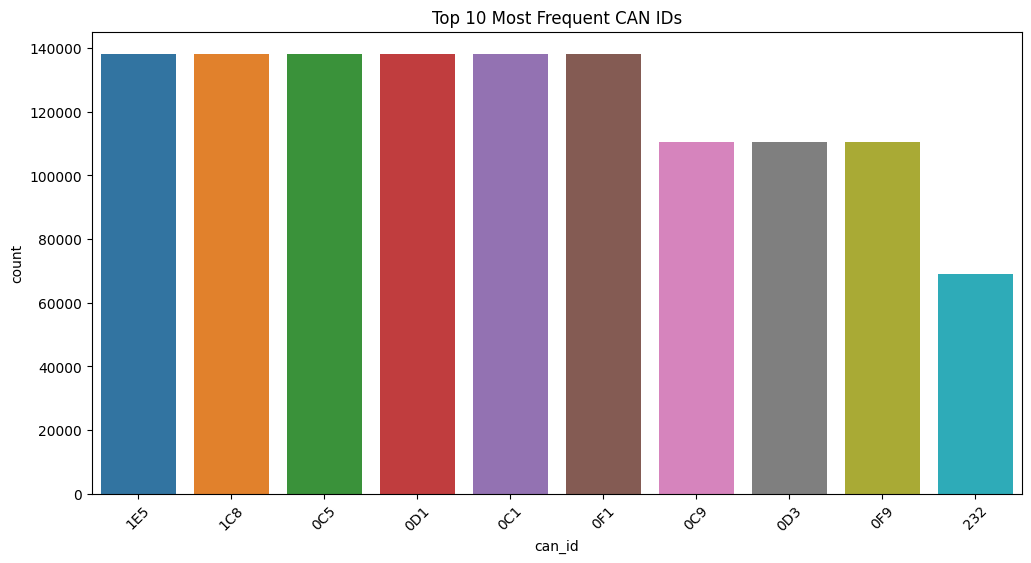

In [1]:
import pandas as pd
import numpy as np
import os
import bz2
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

class CANBusStats:
    def __init__(self):
        self.stats_summary = {}

    def load_data(self, file_path):
        """Decompress and load CAN bus data"""
        extracted_file_path = file_path.replace(".bz2", "")
        
        # Decompress if necessary
        if file_path.endswith(".bz2"):
            with bz2.BZ2File(file_path, "rb") as fr, open(extracted_file_path, "wb") as fw:
                fw.write(fr.read())
            file_path = extracted_file_path

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
        
        data = []
        with open(file_path, "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue  # Skip invalid lines
                try:
                    timestamp = float(parts[0].strip("()"))
                    can_id, payload = parts[2].split("#")

                    data.append({
                        "timestamp": timestamp,
                        "datetime": datetime.fromtimestamp(timestamp),
                        "can_id": can_id,
                        "payload": payload,
                        "payload_length": len(payload),
                    })
                except (ValueError, IndexError):
                    continue  # Skip malformed lines

        df = pd.DataFrame(data)
        print("File loaded successfully! First few rows:")
        print(df.head())
        return df

    def compute_basic_stats(self, df):
        """Compute basic descriptive statistics"""
        if df.empty:
            raise ValueError("Error: DataFrame is empty. Check your input file.")

        self.stats_summary["basic"] = {
            "total_messages": len(df),
            "unique_can_ids": df["can_id"].nunique(),
            "data_duration_seconds": df["timestamp"].max() - df["timestamp"].min(),
            "messages_per_second": len(df) / (df["timestamp"].max() - df["timestamp"].min()),
        }

        # CAN ID statistics
        can_id_counts = df["can_id"].value_counts()
        self.stats_summary["can_id"] = {
            "most_frequent_can_id": can_id_counts.idxmax(),
            "messages_most_frequent": can_id_counts.max(),
            "least_frequent_can_id": can_id_counts.idxmin(),
            "messages_least_frequent": can_id_counts.min(),
        }

        # Temporal statistics
        df["time_diff"] = df["timestamp"].diff()
        self.stats_summary["temporal"] = {
            "mean_interval": df["time_diff"].mean(),
            "median_interval": df["time_diff"].median(),
            "std_interval": df["time_diff"].std(),
            "min_interval": df["time_diff"].min(),
            "max_interval": df["time_diff"].max(),
        }

        print("Computed statistics successfully!")
        return self.stats_summary

    def perform_eda(self, df):
        """Perform EDA including visualizations"""
        if df.empty:
            raise ValueError("Error: DataFrame is empty. Check your input file.")

        # 1. Plot Histograms of numerical columns
        plt.figure(figsize=(12, 8))
        df.hist(bins=50, figsize=(12, 10))
        plt.suptitle("Distribution of Numerical Features")
        plt.show()

        # 2. Boxplots for detecting outliers
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df[['timestamp', 'payload_length']])
        plt.title("Boxplot for Timestamp and Payload Length")
        plt.show()

        
        # 3. Check correlation between numerical features
        numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
        correlation_matrix = numeric_df.corr()  # Compute correlation matrix
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title("Correlation Heatmap")
        plt.show()


        # 4. Plot Temporal Data: Message count over time
        plt.figure(figsize=(12, 6))
        df.set_index('datetime').resample('D').size().plot()
        plt.title("Message Count Over Time")
        plt.xlabel('Date')
        plt.ylabel('Message Count')
        #plt.show()

        # 5. Check for missing values
        missing_data = df.isnull().sum()
        print("Missing Data:\n", missing_data)

        # 6. Class Distribution for CAN IDs
        plt.figure(figsize=(12, 6))
        sns.countplot(x='can_id', data=df, order=df['can_id'].value_counts().index[:10])  # Top 10 can_ids
        plt.title("Top 10 Most Frequent CAN IDs")
        plt.xticks(rotation=45)
        plt.show()

# Example usage:
stats_analyzer = CANBusStats()
file_path = "full_data_capture.log.bz2"
df = stats_analyzer.load_data(file_path)
stats = stats_analyzer.compute_basic_stats(df)
print("\nDescriptive Statistics:")
for category, values in stats.items():
    print(f"\n{category.upper()} Statistics:")
    for key, value in values.items():
        print(f"{key}: {value}")

# Perform EDA
stats_analyzer.perform_eda(df)
